In [1]:
import pandas as pd 
import numpy as np 
import src.tools.download
from src import get_sequence_identities
from src.tools import MMSeqs
from src.dataset import Dataset
from src.files import FASTAFile, GBFFFile
from src.reference import Reference
from src.clusterer import Clusterer
from tqdm import tqdm
import os
import json 
import seaborn as sns
from src import fillna 
import matplotlib.pyplot as plt 
from src.split import ClusterStratifiedShuffleSplit
from Bio.Align import PairwiseAligner

%load_ext autoreload
%autoreload 2

# TODO: There are partial sequences in the training dataset (at least in the spurious class). I am not sure if these are a good idea to
#   include, as there are no partial translations from Prodigal (except sometimes on the edges). How much does start codon value
#   affect the embedding?

# Because genomes are constantly being re-annotated, the GBFF files I downloaded a month or so ago are now not aligned with the 
# protein files I used to generate the most recent round of embeddings (05/23/2025). GBFF files were re-downloaded for 
# the Campylobacterota phylum on 05/25/2025. 

# ncbi = src.tools.download.NCBI()
# ncbi.get_genomes(genome_ids=genome_ids, include=['gbff'], dirs={'gbff':'../data/ncbi/gbffs/'})
# ncbi.cleanup()



In [ ]:
# Want to obtain the actual taxa names from the numbers provided in AntiFam. 
antifam_df = pd.read_csv('../data/antifam_bacteria.csv', index_col=0)

In [3]:
# is_bacterial = lambda df : np.array(['2' in lineage.split(' ') for lineage in df.lineage])

def filter_length(df:pd.DataFrame, max_length:int=2000, seq_col:str='seq'):
    mask = df[seq_col].apply(len) >= max_length
    print(f'filter_length: Removing {mask.sum()} sequences exceeding the maximum length of {max_length}.')
    df = df[~mask].copy()
    return df

def filter_suspect(df:pd.DataFrame):
    # Just checking if the product is "hypothetical protein" is sufficient for removing suspect sequences, as all non-annotated
    # sequences derived from ab initio predictions are assigned this exact label. However, there are homology-derived hypothetical
    # sequences which have different labels (e.g. "Uncharacterized protein")
    mask = (df['product'] == 'hypothetical protein') & (df.evidence_type == 'ab initio prediction')
    print(f'filter_length: Removing {mask.sum()} suspect sequences.')
    df = df[~mask].copy()
    return df

def filter_duplicates(df:pd.DataFrame, seq_col:str='seq'):
    # There are some duplicate IDs, as the same gene can be present in multiple genomes. Additionally, there are
    # some entries for identical sequences which do not have the same ID. This can mess up the bisecting k-means clustering, 
    # so I decided to remove these instances. 
    mask = df[seq_col].duplicated(keep='first')
    print(f'Removing {mask.sum()} duplicate sequences from the dataset')
    df = df[~mask].copy()
    return df 


In [4]:
swissprot_df = pd.read_csv('../data/swissprot.csv', index_col=0)
swissprot_df = swissprot_df[swissprot_df.domain.isin(['Bacteria', 'Viruses'])]

swissprot_df = filter_length(swissprot_df)
swissprot_df = filter_duplicates(swissprot_df)

# Make a FASTA file for generating embeddings for the embeddings library. 
# FASTAFile(df=swissprot_df).write('swissprot.faa')

filter_length: Removing 1310 sequences exceeding the maximum length of 2000.
Removing 138631 duplicate sequences from the dataset


In [ ]:
ncbi = src.tools.download.NCBI()
ncbi.get_taxonomy_metadata(swissprot_df.ncbi_taxonomy_id.unique(), path='../data/swissprot_taxonomy_metadata.tsv')


NCBI._get_metadata: Downloading metadata.:   0%|          | 0/289 [00:00<?, ?it/s]

NCBI._get_metadata: Downloading metadata.:  58%|█████▊    | 168/289 [49:45<36:24, 18.06s/it] 

In [3]:
dataset_df = pd.read_csv('../data/swissprot.csv', index_col=0)
dataset_df = dataset_df[dataset_df.domain.isin(['Bacteria', 'Viruses'])]

antifam_df = pd.read_csv('../data/antifam_bacteria.csv', index_col=0)

dataset_df['library_entry_name'] = 'swissprot' 
antifam_df['library_entry_name'] = 'antifam'

dataset_df = pd.concat([antifam_df.assign(label=0), dataset_df.assign(label=1)])
dataset_df = fillna(dataset_df, rules={str:'none', bool:False, int:0, float:0})

dataset_df = filter_duplicates(dataset_df)
dataset_df = filter_length(dataset_df)

dataset_df.to_csv('../data/datasets/swissprot/dataset.csv')

Removing 144629 duplicate sequences from the dataset
filter_length: Removing 675 sequences exceeding the maximum length of 2000.


In [ ]:
genome_metadata_df = pd.read_csv('../data/genome_metadata.csv', index_col=0)
genome_ids = genome_metadata_df[genome_metadata_df.phylum == 'Campylobacterota'].index.values 

dataset_df = list()
for genome_id in tqdm(genome_ids, desc='Building dataset from NCBI reference.'):
    protein_path = f'../data/ncbi/proteins/{genome_id}_protein.faa'
    gbff_path = f'../data/ncbi/gbffs/{genome_id}_genomic.gbff'

    gbff_df = GBFFFile(gbff_path).to_df()
    gbff_df = gbff_df[(gbff_df.feature == 'CDS') & (~gbff_df.pseudo)].copy()
    gbff_df['copy_number'] = gbff_df.protein_id.map(gbff_df.protein_id.value_counts()) # There are sometimes multiple copies of the same protein. 
    gbff_df = gbff_df.drop_duplicates('protein_id').copy()
    gbff_df = gbff_df.drop(columns=['seq']) # Use the sequences from the protein DataFrame, just to make sure everything is equal. 
    gbff_df = gbff_df.set_index('protein_id')
    gbff_df.index.name = 'id'

    fasta_df = FASTAFile(path=protein_path).to_df(prodigal_output=False)
    fasta_df = fasta_df.drop(columns=['description'])

    assert len(fasta_df) == len(gbff_df), 'Expected the number of non-pseudo CDS entries in the GBFF file to match the entries in the FASTA file.'
    assert np.all(np.sort(fasta_df.index) == np.sort(gbff_df.index)), 'Expected the number of non-pseudo CDS entries in the GBFF file to match the entries in the FASTA file.'
    assert fasta_df.index.is_unique and gbff_df.index.is_unique, 'Expected the indices of both DataFrames to be unique.'

    dataset_df.append(fasta_df.merge(gbff_df, left_index=True, right_index=True).assign(genome_id=genome_id))

dataset_df = pd.concat(dataset_df)
dataset_df = filter_suspect(dataset_df)


In [ ]:
antifam_df = pd.read_csv('../data/antifam_bacteria.csv', index_col=0)

dataset_df['library_entry_name'] = dataset_df.genome_id 
antifam_df['library_entry_name'] = 'antifam'

dataset_df = pd.concat([antifam_df.assign(label=0), dataset_df.assign(label=1)])
dataset_df = fillna(dataset_df, rules={str:'none', bool:False, int:0, float:0})

dataset_df = filter_duplicates(dataset_df)
dataset_df = filter_length(dataset_df)
dataset_df.to_csv('../data/datasets/campylobacterota/dataset.csv')


Removing 394 sequences exceeding the maximum length from the dataset.
Removing 44438 suspect sequences from the dataset.
Removing 9522 duplicate sequences from the dataset


In [ ]:
# dataset_subset_df = dataset_df.sample(5000, random_state=42)
# dataset_subset_df.to_csv('../data/dataset_subset.csv')

In [5]:
mmseqs_cluster_df

,mmseqs_cluster_rep,mmseqs_cluster_id
id,,
B3CM19,B3CM19,0
Q8PJ57,Q8PJ57,1
Q4UWA0,Q8PJ57,1
B0RRB6,Q8PJ57,1
Q3BRP7,Q8PJ57,1
...,...,...
P54907,P54907,64588
P55395,P54907,64588
P18473,P18473,64589


In [ ]:
# What is a good estimate for the number of clusters? Maybe use 50 percent sequence similarity?
# This resulted in about 70000 clusters for the Campylobacterota dataset. 
# This resulted in about 665000 clusters for the SwissProt dataset. 
mmseqs = MMSeqs()
mmseqs_cluster_df = mmseqs.cluster(dataset_df, name='dataset', output_dir='../data/datasets/swissprot', sequence_identity=0.5, overwrite=False)
mmseqs.cleanup()
print('Number of clusters:', mmseqs_cluster_df.mmseqs_cluster_id.nunique())

Number of clusters: 64591


In [3]:
dataset_df = pd.read_csv('../data/dataset_dereplicated.csv', index_col=0)
dataset_df = dataset_df.merge(pd.read_csv('../data/dataset_dereplicated_cluster.csv', index_col=0), left_index=True, right_index=True)

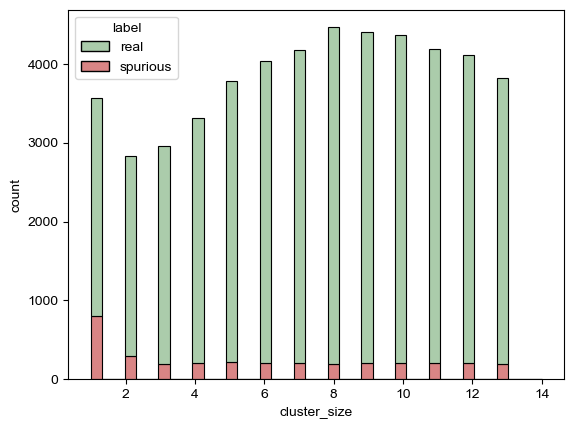

In [28]:
fig, ax = plt.subplots()

ax_df = pd.DataFrame(index=dataset_df.cluster_label.unique())
ax_df['cluster_size'] = dataset_df.groupby('cluster_label').apply(len, include_groups=False)
ax_df['label'] = dataset_df.groupby('cluster_label').label.first()
ax_df['label'] = ax_df.label.replace({0:'spurious', 1:'real'})

palette = {'spurious':'indianred', 'real':'darkseagreen'}

sns.histplot(data=ax_df, x='cluster_size', hue='label', multiple='stack', ax=ax, palette=palette)
ax.set_ylabel('count')

plt.show()

In [ ]:
sequence_identities_df = list()
min_sequence_identity = 1

pbar = tqdm(list(dataset_df.groupby('cluster_label')), desc='Computing sequence identities.')
for cluster_label, df in pbar:
    values = get_sequence_identities(df, as_matrix=False)

    row = dict()
    row['cluster_label'] = cluster_label
    row['mean_sequence_identity'] = values.mean()
    row['min_sequence_identity'] = values.min()
    row['max_sequence_identity'] = values.max()
    row['standard_deviation'] = np.std(values)
    row['n_alignments'] = len(values)
    
    sequence_identities_df.append(row)

    if row['min_sequence_identity'] < min_sequence_identity:
        min_sequence_identity = row['min_sequence_identity']
        pbar.set_description(f'Computing sequence identities. Minimum identity {min_sequence_identity:.2f} found in cluster {cluster_label}.')

pbar.close()
sequence_identities_df = pd.DataFrame(sequence_identities_df).set_index('cluster_label')
sequence_identities_df.to_csv('dataset_dereplicated_cluster_sequence_identities.csv')

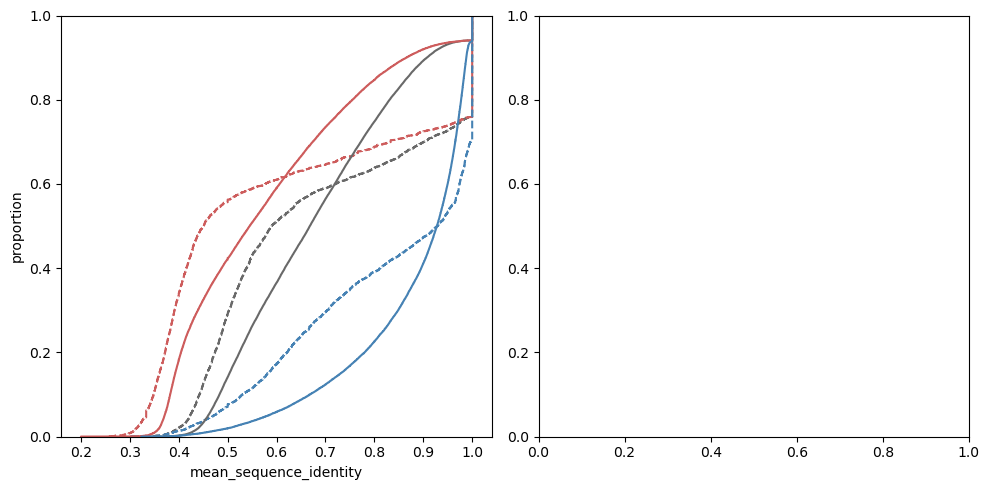

In [ ]:
sequence_identities_df = pd.read_csv('dataset_dereplicated_cluster_sequence_identities.csv', index_col=0)

fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(10, 5))

ax_a_df = sequence_identities_df.copy()
ax_a_df['label'] = dataset_df.groupby('cluster_label').label.first()
palette = {'spurious':'indianred', 'real':'darkseagreen'}

linestyles = {0:'--', 1:'-'}
for label, df in ax_a_df.groupby('label'):
    sns.ecdfplot(data=df, x='mean_sequence_identity', ax=ax_a, color='dimgray', label='mean sequence identity', linestyle=linestyles[label])
    sns.ecdfplot(data=df, x='min_sequence_identity', ax=ax_a, color='indianred', label='min. sequence identity', linestyle=linestyles[label])
    sns.ecdfplot(data=df, x='max_sequence_identity', ax=ax_a, color='steelblue', label='max. sequence identity', linestyle=linestyles[label])
ax_a.set_ylabel('proportion')

ax_b_df = pd.DataFrame(index=dataset_train_df.cluster_label.unique())

ax_b_df['cluster_size'] = ax_b_df.index.map(dataset_df.groupby('cluster_label').apply(len, include_groups=False))
# ax_b_df = ax_b_df.merge(sequence_identities_df, left_index=True, right_index=True)
# ax_b_df = ax_b_df.sort_values('min_sequence_identity').copy().iloc[:1000]

# sns.scatterplot(data=ax_b_df, x='min_sequence_identity', y='max_sequence_identity', ax=ax_b, color='dimgray')

fig.tight_layout()
plt.show()

In [ ]:

prodigal_df = list()
for genome_id in genome_ids:
    top_hits_df = Reference.load(f'../data/compare/{genome_id}_top_hits.csv')
    top_hits_df['genome_id'] = genome_id
    prodigal_df.append(top_hits_df)
prodigal_df = pd.concat(prodigal_df)
prodigal_df = filter_length(prodigal_df)


Removing 383 sequences which exceed the maximum length.
